In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import dataprocess.data_handler_03 as dh
warnings.filterwarnings("ignore")

# Data

In [2]:
# load all spike data from file
spikes_dp = '../../data/original_files/spikes.csv'
binned_data = np.loadtxt(spikes_dp, delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1
        
print('grouped_data.shape = ', grouped_data.shape)

grouped_data.shape =  (297, 1141, 1)


In [3]:
def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

def transform_mnistsift(fv):
    return fv[::16]

def transform_slowfast(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[::100]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

def transform_sift3d(fv):
    return fv[::10]

def transform_parham(fv):
    return fv[::5]

# data retrieval params
data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
               'spike_data': None, 'group_id': None, 'transform': transform_mnistsift, 'ind_min': 0, 'ind_max': 13203, 'feature_id':'mnist-sift'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/slowfast/slowfast_4732_numpy/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_slowfast, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'slowfast'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/sift3d/fvs_s1/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_sift3d, 'ind_min': 1*1141+0, 'ind_max': 2*1141-1, 'feature_id':'sift3d'}

# data_params = {'func': dh.datapoint_numpy, 'lbl_func': dh.get_labels, 'features_dp': '../../data/features/parham/parham3/features_2layer/', \
#                'spike_data': grouped_data, 'group_id': 0, 'transform': transform_parham, 'ind_min': 1*1141+41, 'ind_max': 2*1141-1, 'feature_id':'parham'}


train_num = 600
val_num = 100
seed = None

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, data_params, seed)

# optional normalization
# train_data['des'] = dh.normalize(train_data['des'])
# val_data['des'] = dh.normalize(val_data['des'])

# show statistics
print('feature_id: ', data_params['feature_id'])
print('train_num = ', train_num, ', val_num = ', val_num)
print('number of features: ', train_data['des'].shape[1])
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))

# print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
# print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
# print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

feature_id:  mnist-sift
train_num =  600 , val_num =  100
number of features:  16
training data contains 300 points (50.00%) of label 1.
validation data contains 50 points (50.00%) of label 1.


In [7]:
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
knn.fit(train_data['des'], train_data['lbls'])
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(train_data['des'], train_data['lbls'])))

# validation
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(val_data['des'], val_data['lbls'])))

Accuracy of K-NN classifier on training set: 0.97
Accuracy of K-NN classifier on test set: 0.93


In [10]:
y_est = knn.predict(val_data['des'])
print('Predicted labels: ', y_est)

Predicted labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1.  1.  1.
  1.  1.  1.  1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1. -1.
 -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


## Scale feature vectors before training

In [11]:
# with scaling
scaler = StandardScaler()
train_X = scaler.fit_transform(train_data['des'])
val_X = scaler.transform(val_data['des'])

knn2 = KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='auto')
knn2.fit(train_X, train_data['lbls'])
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn2.score(train_X, train_data['lbls'])))

# validation
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn2.score(val_X, val_data['lbls'])))

Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.94


# Hyperparameter tuning

In [12]:
k_values = [i for i in range (1,31)]
scores = []

# merge training and validation data
X = np.append(train_data['des'], val_data['des'], axis=0)
y = np.append(train_data['lbls'], val_data['lbls'], axis=0)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='auto')
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

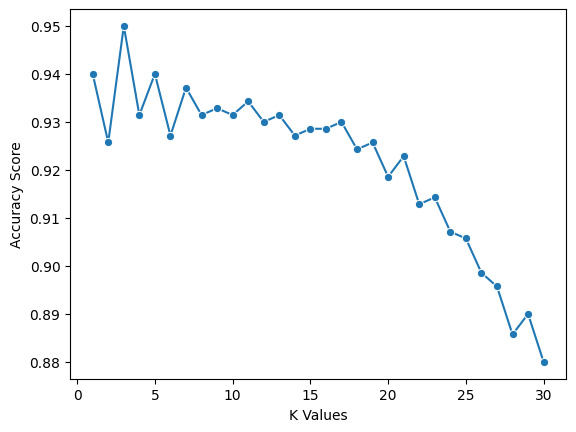

In [13]:
# plot
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")